In [2]:
import numpy as np
import pandas as pd 
import datetime as dt 
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365 * years)


In [4]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [10]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate, auto_adjust= False)
    adj_close_df[ticker] = data["Adj Close"]
print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2010-03-08   86.739983  51.822254  109.879997   40.642269   44.442287
2010-03-09   86.884201  51.854912  109.720001   40.869377   44.533867
2010-03-10   87.271362  51.815727  108.470001   41.201298   44.770519
2010-03-11   87.635681  51.809170  108.599998   41.358509   44.938457
2010-03-12   87.643318  51.828800  107.949997   41.367260   44.938457
...                ...        ...         ...         ...         ...
2025-02-24  597.210022  72.870003  272.209991  519.869995  294.410004
2025-02-25  594.239990  73.330002  268.619995  513.320007  292.950012
2025-02-26  594.539978  73.440002  269.029999  514.559998  293.049988
2025-02-27  585.049988  73.349998  264.929993  500.269989  288.510010
2025-02-28  594.179993  73.660004  263.269989  508.170013  292.959991

[3770 rows x 5 columns]


Calculate the daily log returns and drop na

In [11]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2010-03-09  0.001661  0.000630 -0.001457  0.005572  0.002059
2010-03-10  0.004446 -0.000756 -0.011458  0.008089  0.005300
2010-03-11  0.004166 -0.000127  0.001198  0.003808  0.003744
2010-03-12  0.000087  0.000379 -0.006003  0.000212  0.000000
2010-03-15  0.000259  0.001385  0.003791 -0.002537 -0.000340
...              ...       ...       ...       ...       ...
2025-02-24 -0.004561  0.001373  0.005415 -0.011875 -0.005116
2025-02-25 -0.004986  0.006293 -0.013276 -0.012679 -0.004971
2025-02-26  0.000505  0.001499  0.001525  0.002413  0.000341
2025-02-27 -0.016091 -0.001226 -0.015357 -0.028164 -0.015613
2025-02-28  0.015485  0.004217 -0.006286  0.015668  0.015306

[3769 rows x 5 columns]


Create a function that calculate Exp return (We do assume that futur returns are expected to be as the past returns --> not the most accurate are reliable)

In [12]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

In [13]:
def standard_dev(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Create the Cov_matrix for all the securities

In [34]:
cov_matrix = log_returns.cov()


create an equally weighted PF

In [20]:
portfolio_value = 1000000

weights = np.array([1/len(tickers)]*len(tickers))

portfolio_expected_return = expected_return(weights, log_returns)

portfolio_std_dev = standard_dev(weights, cov_matrix)

Creation of a function that gives a random Z-score based on normal distribution

In [21]:
def random_z_score():
    return np.random.normal(0,1)

Create a function to calculate scenario GainLoss

In [22]:
days = 5

def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

Run 10000 Simulations

In [23]:
simulations = 10000
scenarioReturn = []

for i in range (simulations):
    z_score = random_z_score()
    scenarioReturn.append(scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days))

In [28]:
confidence_interval = 0.95
VaR = -np.percentile(scenarioReturn, 100 * (1 - confidence_interval))
print(VaR)

24593.618826311755


Plot the results

<function matplotlib.pyplot.show(close=None, block=None)>

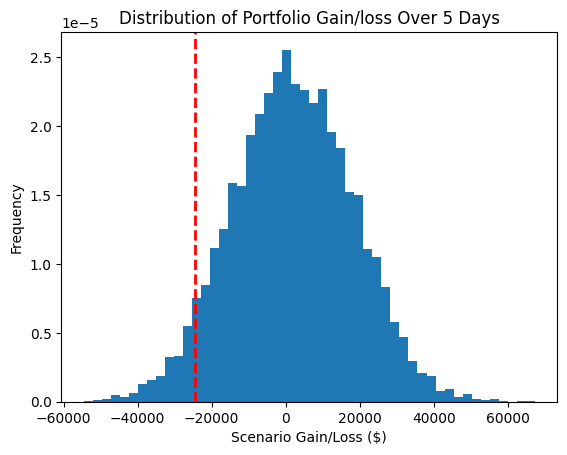

In [33]:
plt.hist(scenarioReturn, bins = 50, density = True)
plt.xlabel('Scenario Gain/Loss ($)')
plt.ylabel('Frequency')
plt.title(f'Distribution of Portfolio Gain/loss Over {days} Days')
plt.axvline(-VaR, color = 'r', linestyle = 'dashed', linewidth = 2, label = f'VaR at {confidence_interval: .0%} confidence level')
plt.legend
plt.show